# Programmentwurf Künstliche Intelligenz

## Thema :  Evidenztheorie und Case Based Reasoning

### Namen der Studierenden: 

(Hinweis: Es sind Namen anzugeben und keine Matrikelnummern. Matrikelnummern werden ausschließlich bei Klausuren zur Anonymisierung verwendet)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Einlesen der CSV-Datei
file_path = 'bikedata/sampled_data_001.csv'   # Einsetzen!
data = pd.read_csv(
    file_path,
    sep=";",
    decimal=",",
    keep_default_na=True,
    na_values=["", " ", "NA", "NaN", "nan", "None", None]
)

# Robust: Spaltennamen und Stringwerte trimmen
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].str.strip()
    data[col] = data[col].replace({"": pd.NA})

# Robuste Numerik-Konvertierung für bekannte numerische Spalten (Fehlerhafte Strings -> NaN)
num_cols_expected = ['Distance', 'Elevation Gain', 'Moving Time', 'Average Speed']
for col in [c for c in num_cols_expected if c in data.columns]:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Einfache Qualitätsprüfung
print('Dataset shape:', data.shape)
print('\nInfo:')
print(data.info())
print('\nNaN pro Spalte:')
print(data.isna().sum().sort_values(ascending=False).to_string())

# Optional: Label-Verteilung (falls vorhanden)
if 'Bike Type' in data.columns:
    allowed = ['race bike', 'mtb', 'trecking bike']
    bt = data['Bike Type'].astype('string').str.strip().str.lower()
    bt = bt.replace({'': pd.NA, 'nan': pd.NA, 'none': pd.NA})
    unknown = sorted(set(bt.dropna().unique()) - set(allowed))
    if unknown:
        print('Warnung: Unerwartete Labels in Bike Type:', unknown)
    data['Bike Type'] = pd.Categorical(bt, categories=allowed)

    # Übersicht
    print('\nLabel-Verteilung (Bike Type) inkl. NaN:')
    print(data['Bike Type'].value_counts(dropna=False))
    labeled = int(data['Bike Type'].notna().sum())
    unlabeled = int(data['Bike Type'].isna().sum())
    print(f'\nGelabelt: {labeled} | Unlabeled: {unlabeled} ({unlabeled/(labeled+unlabeled):.1%})')

Dataset shape: (247, 7)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Distance        247 non-null    float64
 1   Moving Time     247 non-null    int64  
 2   Elevation Gain  247 non-null    float64
 3   Time            247 non-null    object 
 4   Month           247 non-null    int64  
 5   Day             247 non-null    int64  
 6   Bike Type       189 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 13.6+ KB
None

NaN pro Spalte:
Bike Type         58
Distance           0
Moving Time        0
Elevation Gain     0
Time               0
Month              0
Day                0

Label-Verteilung (Bike Type) inkl. NaN:
Bike Type
race bike        105
trecking bike     61
NaN               58
mtb               23
Name: count, dtype: int64

Gelabelt: 189 | Unlabeled: 58 (23.5%)


#### Etwas Analyse vorab ... gerne erweitern

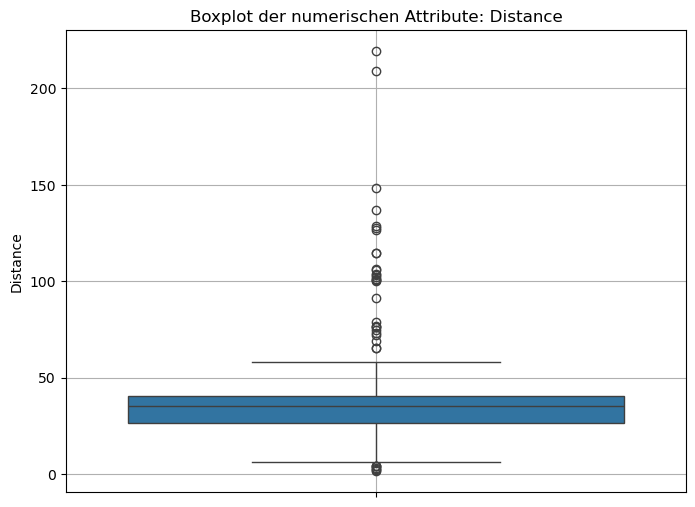

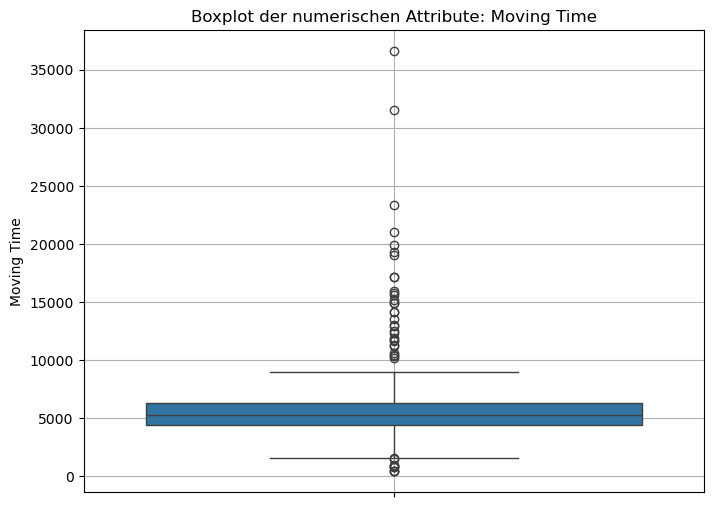

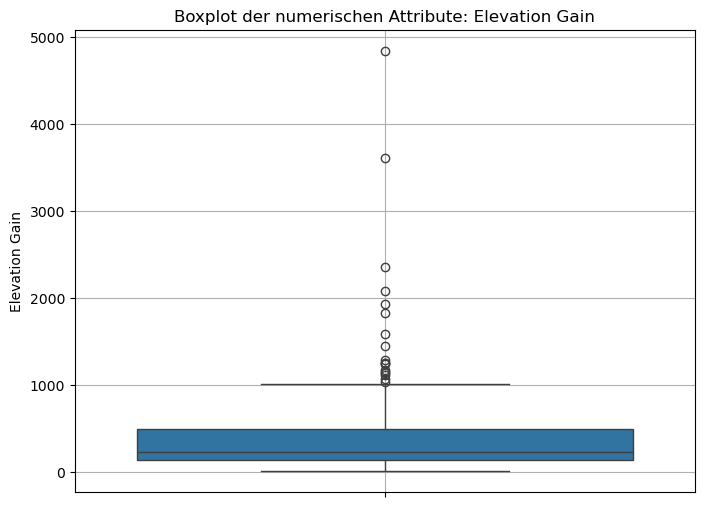

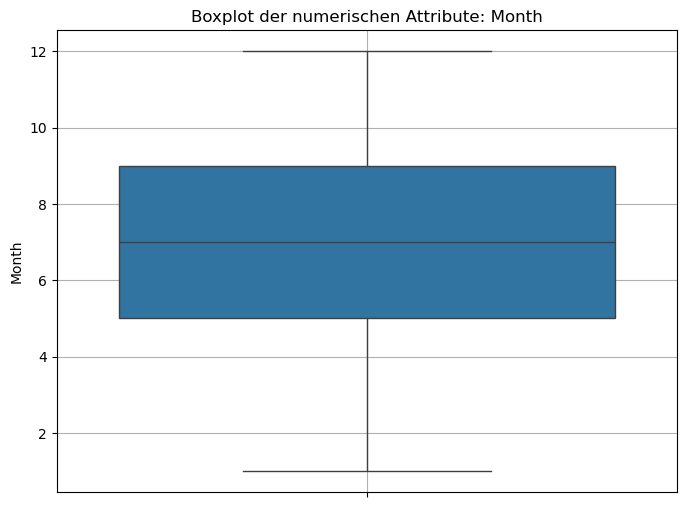

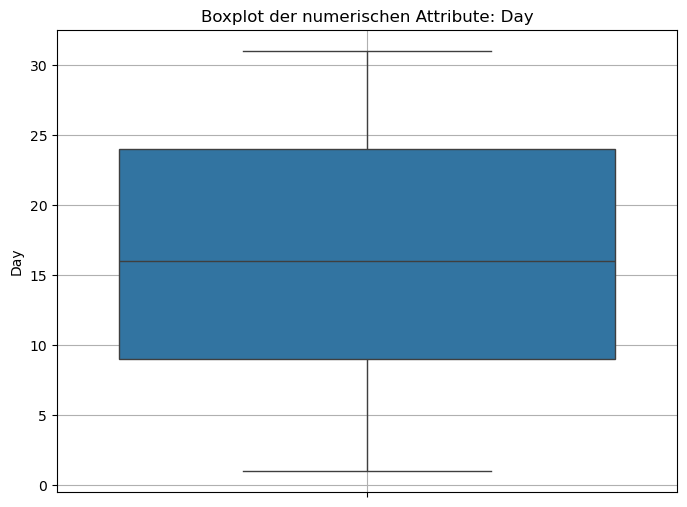

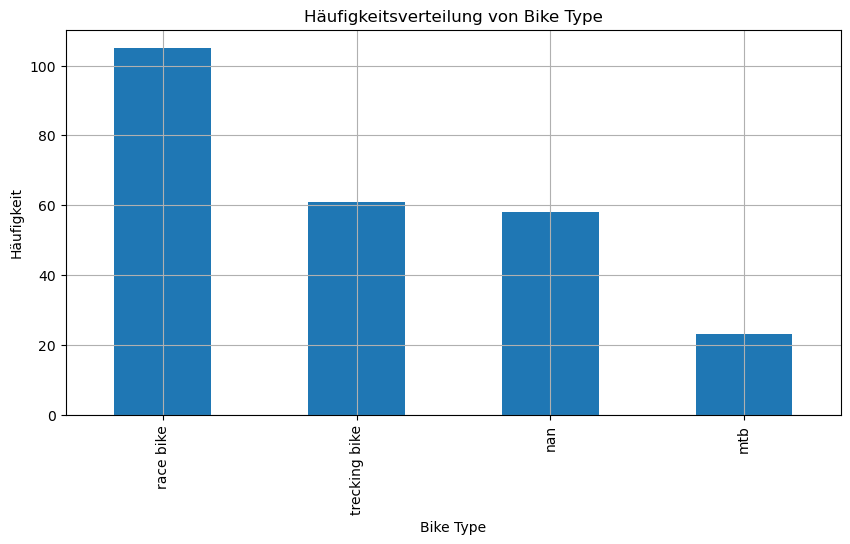

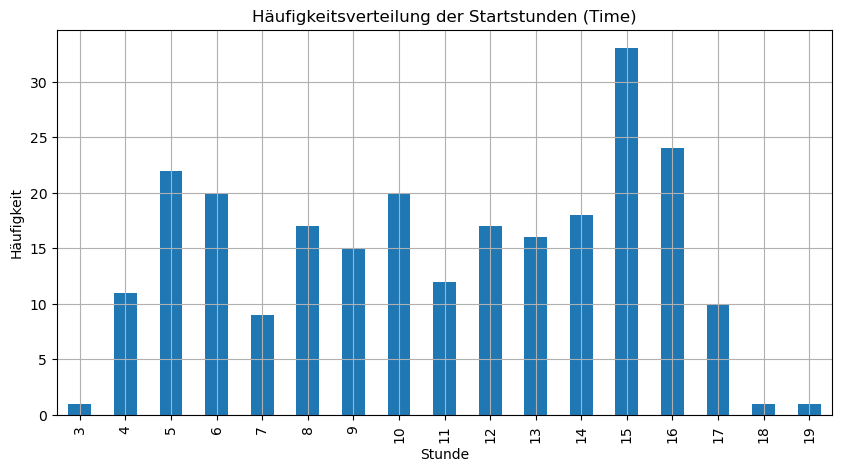

In [2]:
# Numerische Attribute - Boxplots für stetige Variablen
numeric_columns = data.select_dtypes(include='number').columns
continuous_columns = [col for col in numeric_columns if data[col].nunique(dropna=True) > 10]
discrete_numeric_columns = [col for col in numeric_columns if col not in continuous_columns]

for column in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=data[column])
    plt.title(f'Boxplot der numerischen Attribute: {column}')
    plt.ylabel(column)
    plt.grid(True)
    plt.show()

# Diskrete numerische Attribute - Häufigkeitsverteilungen
for column in discrete_numeric_columns:
    counts = data[column].value_counts(dropna=False).sort_index()
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

# Kategoriale Attribute - Häufigkeitsverteilungen
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col != 'Time']

for column in categorical_columns:
    counts = data[column].value_counts(dropna=False)
    plt.figure(figsize=(10, 5))
    counts.plot(kind='bar')
    plt.title(f'Häufigkeitsverteilung von {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')
    plt.grid(True)
    plt.show()

# Zeit als Tagesstunde aggregieren
if 'Time' in data.columns:
    time_hours = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.hour.dropna()
    if not time_hours.empty:
        counts = time_hours.value_counts().sort_index()
        plt.figure(figsize=(10, 5))
        counts.plot(kind='bar')
        plt.title('Häufigkeitsverteilung der Startstunden (Time)')
        plt.xlabel('Stunde')
        plt.ylabel('Häufigkeit')
        plt.grid(True)
        plt.show()


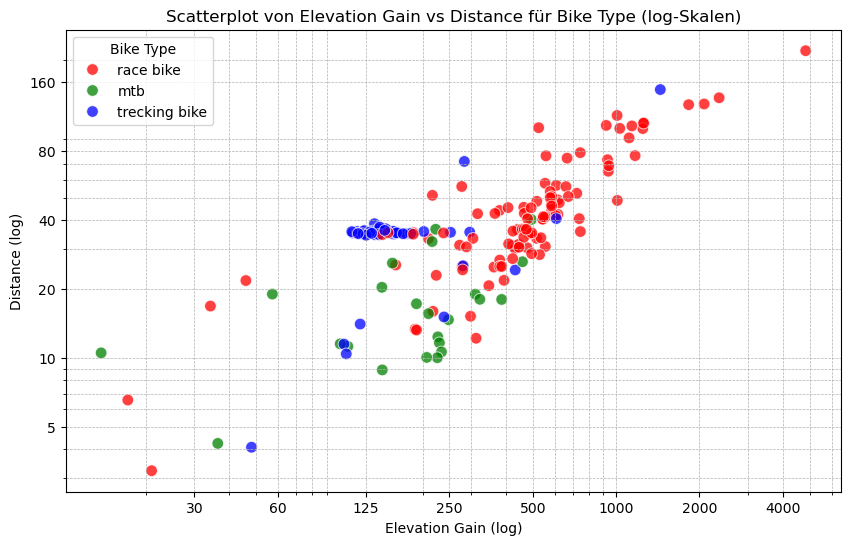

In [37]:
# Scatterplot für Elevation Gain und Distance basierend auf Bike Type
plt.figure(figsize=(10, 6))
colors = {'race bike': 'red', 'mtb': 'green', 'trecking bike': 'blue'}
sns.scatterplot(
    data=data,
    x='Elevation Gain',
    y='Distance',
    hue='Bike Type',
    palette=colors,
    alpha=0.75,
    s=70
)
plt.xscale('log')
plt.yscale('log')
distance_ticks = [5, 10, 20, 40, 80, 160]
elevation_ticks = [30, 60, 125, 250, 500, 1000, 2000, 4000]
plt.yticks(distance_ticks, [str(t) for t in distance_ticks])
plt.xticks(elevation_ticks, [str(t) for t in elevation_ticks])
plt.title('Scatterplot von Elevation Gain vs Distance für Bike Type (log-Skalen)')
plt.xlabel('Elevation Gain (log)')
plt.ylabel('Distance (log)')
plt.grid(True, which='both', ls='--', linewidth=0.5)
plt.show()


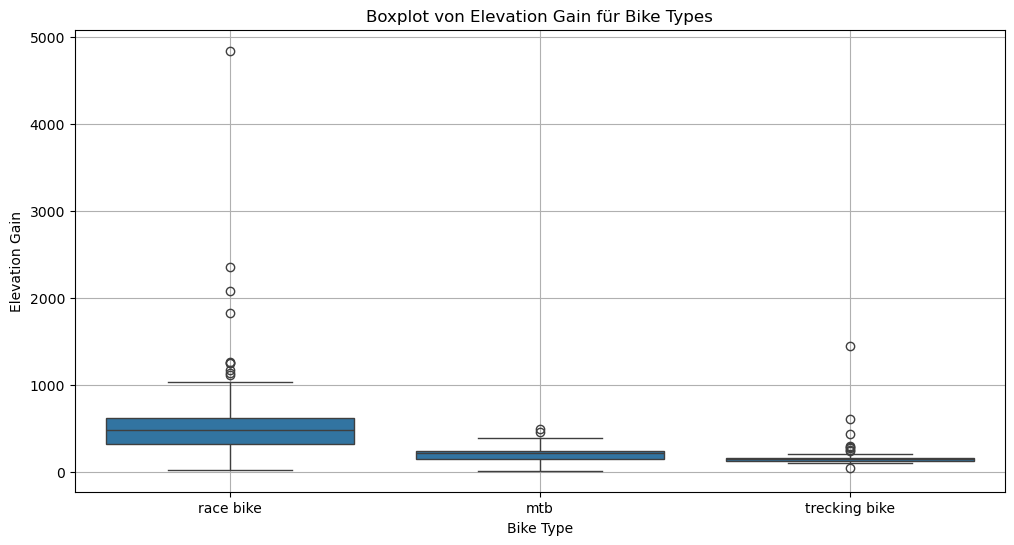

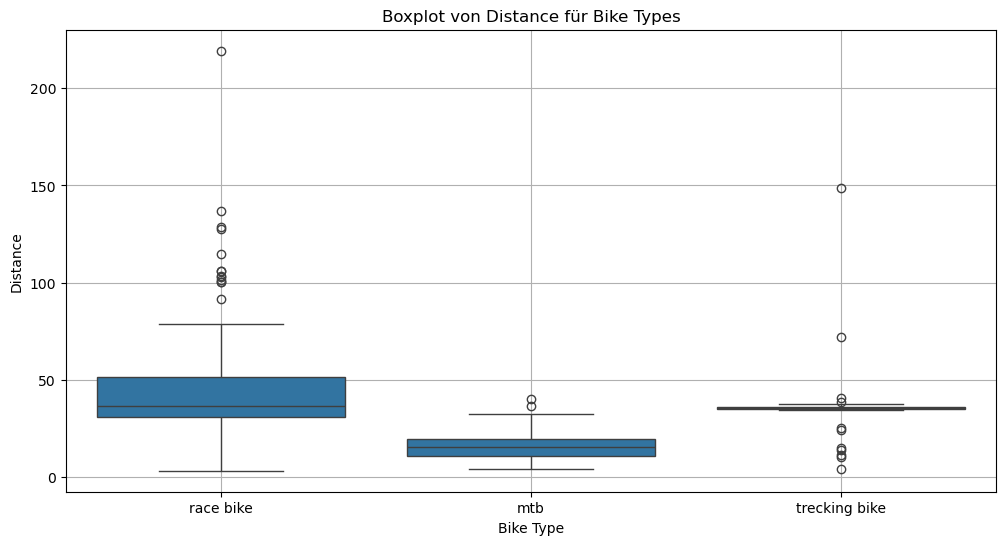

In [4]:
# Boxplots für Elevation Gain und Distance

# Boxplot für Elevation Gain
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Elevation Gain', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Elevation Gain für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Elevation Gain')
plt.grid(True)
plt.show()

# Boxplot für Distance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bike Type', y='Distance', data=data, order=['race bike', 'mtb', 'trecking bike'])
plt.title('Boxplot von Distance für Bike Types')
plt.xlabel('Bike Type')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

## Aufgabenteil 1: Evidenztheorie

Entwerfen Sie ein KI Modell auf Basis von Evidenztheorie und setzen Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Fuzzy Mengen zur Bewertung und Integration der Evidenzwerte.


In [5]:
# !pip install py_dempster_shafer

from pyds import MassFunction

# Klassen (Bikes) als Einzelzeichen: r=race bike, m=mtb, t=trecking bike
CLASSES = ['r','m','t']
omega = 'rmt'  # Omega = Gesamtraum


### 1. Daten vorverarbeiten

Wir bereiten den Datensatz so auf, dass er direkt für fuzzy-basierte Evidenz kombiniert werden kann.
- Numerische Spalten (`Distance`, `Elevation Gain`) konvertieren wir in Floats und entfernen fehlerhafte Einträge.
- Kategoriale Felder werden getrimmt (z. B. Bike-Typen) und NaNs sauber behandelt.
- Für die Fuzzy-Definition orientieren wir uns an quantilbasierten Grenzen, damit sich die Mengen an die beobachteten Verteilungen anpassen.


In [6]:
# (Vgl. Labor Evidenztheorie: Fuzzy-Funktionen jetzt über Quantile definiert)
import numpy as np

def analyze_feature(series, q_low=0.20, q_mid_low=0.45, q_mid_high=0.70, q_high=0.90):
    s = series.astype(float)
    s = s[np.isfinite(s)]
    if s.size == 0:
        raise ValueError('Leere Serie für Fuzzy-Analyse')

    q_low_val, q_mid_low_val, q_mid_high_val, q_high_val = np.nanpercentile(
        s,
        [q_low * 100, q_mid_low * 100, q_mid_high * 100, q_high * 100]
    )
    min_v = float(np.nanmin(s))
    max_v = float(np.nanmax(s))

    def safe_div(num, denom):
        return num / denom if denom != 0 else 0.0

    def low(x):
        if x <= q_low_val:
            return 1.0
        if x >= q_mid_low_val:
            return 0.0
        return max(0.0, safe_div(q_mid_low_val - x, q_mid_low_val - q_low_val))

    def medium(x):
        if x <= q_low_val or x >= q_mid_high_val:
            return 0.0
        if q_low_val < x < q_mid_low_val:
            return safe_div(x - q_low_val, q_mid_low_val - q_low_val)
        if q_mid_low_val <= x <= q_mid_high_val:
            return safe_div(q_mid_high_val - x, q_mid_high_val - q_mid_low_val)
        return 0.0

    def high(x):
        if x >= q_high_val:
            return 1.0
        if x <= q_mid_high_val:
            return 0.0
        return max(0.0, safe_div(x - q_mid_high_val, q_high_val - q_mid_high_val))

    stats = {
        'min': min_v,
        'q_low': q_low_val,
        'q_mid_low': q_mid_low_val,
        'q_mid_high': q_mid_high_val,
        'q_high': q_high_val,
        'max': max_v
    }
    return low, medium, high, stats

# Fuzzy-Funktionen für Distance und Elevation Gain erzeugen
dist_low, dist_med, dist_high, dist_stats = analyze_feature(
    data['Distance'],
    q_low=0.20,
    q_mid_low=0.50,
    q_mid_high=0.62,
    q_high=0.85
)
elev_low, elev_med, elev_high, elev_stats = analyze_feature(
    data['Elevation Gain'],
    q_low=0.25,
    q_mid_low=0.50,
    q_mid_high=0.58,
    q_high=0.80
)

# Hilfsfunktion: beste Kategorie und Zugehörigkeitsgrad
def best_category(funcs, x):
    vals = {name: max(0.0, min(1.0, f(float(x)))) for name, f in funcs.items()}
    cat = max(vals, key=vals.get)
    return cat, vals[cat]


### Begründung zur Wahl der Fuzzy Mengen

- Ziel: Aus den kontinuierlichen Attributen `Distance` (km) und `Elevation Gain` (m) Evidenzen für die Klassen `race bike`, `mtb`, `trecking bike` abzuleiten.
- Datenbasis: Die Erkundung (Boxplots, Scatterplot mit Log-Skalierung) zeigt, dass Rennradfahrten sowohl bei Distanz als auch Höhenmetern das obere Spektrum dominieren, Mountainbike-Fahrten kürzere Strecken mit mittleren Höhenmetern abdecken und Trekkingfahrten im unteren Höhenmeter-Bereich liegen.
- Ansatz (analog zum Evidence-Lab): Stückweise lineare Fuzzy-Mengen `low/medium/high`, wobei `medium` um den datengetriebenen Mittelwert ±10 % definiert ist. Die Übergänge bleiben durch lineare Rampen interpretierbar.
- Mapping der Fuzzy-Kategorien auf Klassen (aktualisiert nach Datenanalyse):
  - `Distance`: high → `race bike`, medium → `trecking bike`, low → `mtb`.
  - `Elevation Gain`: high → `race bike`, medium → `mtb`, low → `trecking bike`.
- Evidenzableitung je Merkmal: Winner-takes-all bestimmt die stärkste Kategorie; deren Zugehörigkeitsgrad μ dient als Massengewicht. Ein Anteil α=0.8 der Masse geht auf das Singleton, der Rest (0.2) auf Ω (Ignoranz), um Unsicherheit zu modellieren.
- Begründung: Die Zuordnung reflektiert die beobachtete Verteilung im Datensatz und bleibt gleichzeitig gut erklärbar. Die ±10 %-Zone liefert eine robuste Toleranz; bei Bedarf kann über Quantile oder trapezförmige Mengen nachjustiert werden.
- Alternativen: Soft-Voting über alle Kategorien statt Winner-takes-all, zusätzliche Merkmale (z. B. `Moving Time`) als weitere Evidenzquellen, oder α-Tuning (0.6–0.9) zur Sensitivitätsanalyse.


### 2. Daten mit Evidenztheorie verarbeiten

Zusammenführen der Daten durch Akkumulation (Dempsters Regel).

In [7]:
# Evidenz aus Fuzzy-Kategorien ableiten und per Dempster kombinieren (vgl. Übungsblatt)

# Mapping der Fuzzy-Kategorien auf Klassen-Buchstaben
dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}  # kurz→mtb, mittel→trekking, lang→race
elev_to_cls = {'low': 't', 'medium': 'm', 'high': 'r'}  # wenig→trekking, mittel→mtb, viel→race

alpha = 0.8  # Anteil für Singletons, Rest an Omega (Unsicherheit)
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}

preds = []
masses = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance']); e = float(row['Elevation Gain'])
    except Exception:
        preds.append(None); masses.append(None); continue

    cat_d, mu_d = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
    cat_e, mu_e = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha * mu_d, omega: 1 - alpha * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha * mu_e, omega: 1 - alpha * mu_e})
    m3 = m1 & m2

    scores = {c: (m3[c] if c in m3 else 0.0) for c in CLASSES}
    best = max(scores, key=scores.get)
    preds.append(label_map[best])
    masses.append(m3)

data['Pred_DS'] = preds


### Begründungen

- Evidenzquellen: Wir nutzen zwei weitgehend unabhängige Merkmale (`Distance`, `Elevation Gain`) als getrennte Evidenzquellen – konsistent mit der Annahme schwacher Unabhängigkeit in Dempster–Shafer.
- Von Fuzzy zu Evidenz: Pro Merkmal wird per Winner-takes-all die stärkste Kategorie gewählt; deren Zugehörigkeit μ bildet die Vertrauensstärke der Evidenz. So entsteht je Merkmal ein einfaches Basismaß mit Singleton und Ω.
- Ω (Ignoranz): Ein Anteil 1−α (hier 0.2) geht auf Ω, um Überkonfidenz zu vermeiden und Unsicherheit (Überlappungen/Schwankungen) explizit zu modellieren.
- Dempsters Regel: Die Kombination verdichtet übereinstimmende Evidenzen und dämpft widersprüchliche durch den Konfliktterm K (Normierung über 1−K). Hoher Konflikt führt zu höherer Masse auf Ω.
- Entscheidungsregel: Auswahl der Klasse mit der höchsten Singleton-Masse. Alternativ wäre BetP (pignistische Wahrscheinlichkeit) möglich; wir bleiben beim lab-nahen, transparenten Max-Mass-Kriterium.
- Parametrik: α=0.8 (stärkerer Fokus auf die Merkmalsevidenz, dennoch Restunsicherheit). Die ±10%-Zone für `medium` kommt aus der datengetriebenen Lab-Heuristik und kann per Validierung feinjustiert werden.
- Mapping (Domänenwissen): `Distance` high→race, medium→trekking, low→mtb; `Elevation Gain` high→mtb, medium→race, low→trekking. Dies reflektiert typische Nutzungsprofile.
- Grenzen und Erweiterungen: Weitere Merkmale (z. B. `Moving Time`, Saison) könnten als zusätzliche Evidenzquellen integriert werden; Soft-Voting über alle drei Fuzzy-Kategorien (statt Winner-takes-all) reduziert Informationsverlust, erhöht aber Komplexität.


### 3. Test und Bewertung 

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration und testen Sie geeignet. 

In [8]:
# Evaluation Evidenztheorie
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')]
if len(df_eval) > 0:
    acc = (df_eval['Pred_DS'] == df_eval['Bike Type']).mean()
    print(f'Accuracy (DS): {acc:.3f}  | n={len(df_eval)}  | alpha={alpha}')
else:
    print('Keine gelabelten Daten für die Bewertung vorhanden.')


Accuracy (DS): 0.709  | n=189  | alpha=0.8


### Erweiterte Bewertung (Evidenztheorie)

Wir ergänzen eine zeilennormierte Konfusionsmatrix sowie präzisere Klassenmetriken (Precision/Recall/F1) und analysieren die Beziehung zwischen Ω (Ignoranz) und Treffergenauigkeit. Zusätzlich wird die Sensitivität gegenüber α untersucht.

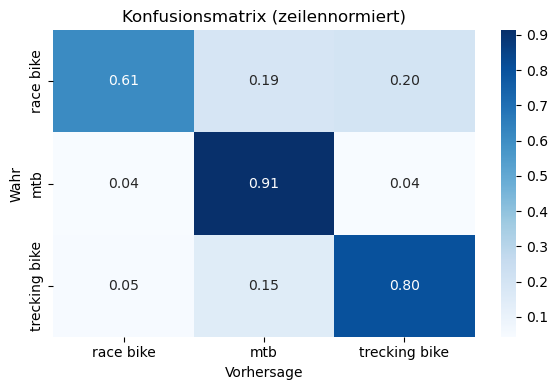

,precision,recall,f1-score,support
race bike,0.941,0.610,0.740,105
mtb,0.420,0.913,0.575,23
trecking bike,0.690,0.803,0.742,61


In [9]:
# Konfusionsmatrix & Klassifikationsbericht (sklearn)
from sklearn.metrics import confusion_matrix, classification_report

labels = ['race bike', 'mtb', 'trecking bike']
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval = df_eval[df_eval['Pred_DS'].notna()]

if df_eval.empty:
    print('Keine gelabelten und vorhergesagten Daten verfügbar.')
else:
    y_true = df_eval['Bike Type']
    y_pred = df_eval['Pred_DS']

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = np.divide(cm, cm.sum(axis=1, keepdims=True), where=cm.sum(axis=1, keepdims=True) != 0)
    cm_df = pd.DataFrame(cm_norm, index=labels, columns=labels)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_df, annot=True, fmt='.2f', cmap='Blues')
    plt.title('Konfusionsmatrix (zeilennormiert)')
    plt.xlabel('Vorhersage')
    plt.ylabel('Wahr')
    plt.tight_layout()
    plt.show()

    report_dict = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report_dict).T.loc[labels]
    report_df['support'] = report_df['support'].astype(int)
    display(report_df[['precision', 'recall', 'f1-score', 'support']].round(3))


### Fehlklassifikationsanalyse

Wir untersuchen die Fälle, in denen `Pred_DS` nicht dem wahren `Bike Type` entspricht, um die Fuzzy-Mengen gezielt nachzuschärfen. Die Tabelle und Boxplots zeigen, in welchen Distanz- und Höhenmeter-Bereichen Verwechslungen auftreten und wie hoch die zugehörige Ω-Masse (Ignoranz) ausfällt. Daraus leiten wir ab:

- Rennrad wird häufig mit MTB oder Trekking verwechselt, wenn Distanz und Höhenmeter im Übergangsbereich unserer aktuellen Fuzzy-Grenzen liegen (≈ 30–35 km / 250–350 HM). Die hohe Ω-Masse signalisiert Konflikte zwischen den Quellen.
- Kurze Trekking-Fahrten mit moderaten Höhenmetern kippen fälschlich zu MTB, sobald `μ_elev_medium` dominiert.
- Die gewonnenen Statistiken liefern konkrete Hinweise, welche Quantile bzw. Rampen zu verschieben sind (z. B. früherer Start von `dist_high`, schmalerer Elevation-Mittelbereich).

Damit verknüpfen wir die explorative Analyse aus den Histogrammen mit konkreten Anpassungen der Fuzzy-Mengen und behalten die Wirkung unserer Änderungen nachvollziehbar im Blick.


,Distance,Elevation Gain,Bike Type,Pred_DS,Omega
2,40.27,494.11,mtb,race bike,0.293632
3,3.23,21.00,race bike,mtb,0.111111
7,25.50,160.00,race bike,mtb,0.212132
12,4.09,48.20,trecking bike,mtb,0.111111
16,14.09,119.00,trecking bike,mtb,0.111111
19,31.11,272.00,race bike,trecking bike,0.406899
26,35.64,140.00,race bike,trecking bike,0.192692
33,33.25,210.00,race bike,trecking bike,0.208555
53,15.24,298.00,race bike,mtb,0.199920
68,25.14,278.00,race bike,mtb,0.227303


Fehlklassifikationen pro Paar:


Distance            Elevation Gain              \
                              median       mean         median        mean   
Bike Type     Pred_DS                                                        
race bike     mtb             21.835  19.415500         278.50  246.865000   
              trecking bike   33.660  33.244762         304.00  321.620000   
mtb           race bike       40.270  40.270000         494.11  494.110000   
              trecking bike   25.990  25.990000         155.57  155.570000   
trecking bike mtb             15.130  19.548889         202.00  198.051111   
              race bike       72.160  87.093333         608.00  778.333333   

                                Omega  
                                 mean  
Bike Type     Pred_DS                  
race bike     mtb            0.182219  
              trecking bike  0.257103  
mtb           race bike      0.293632  
              trecking bike  0.212886  
trecking bike mtb            0.193023  
              race bike      0.127407

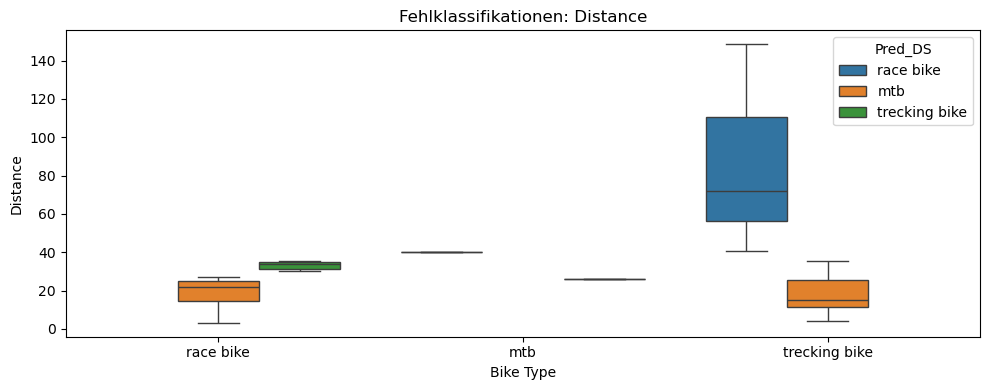

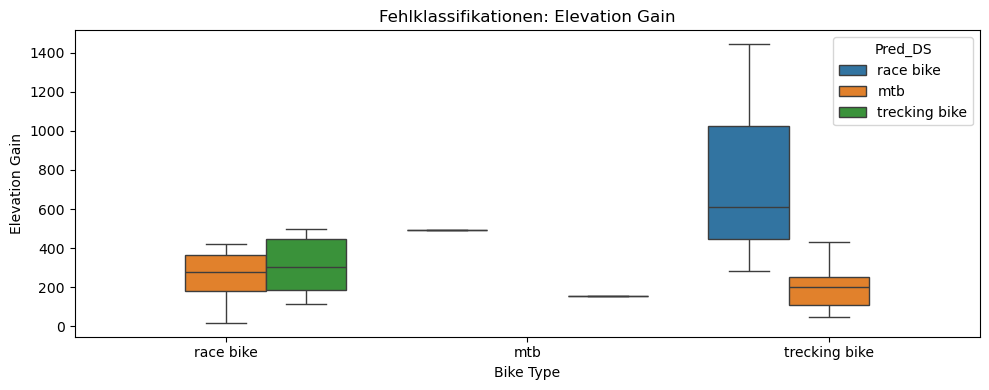

In [10]:
# Fehlklassifikationen analysieren
if 'masses' not in globals():
    raise RuntimeError('masses fehlt – bitte DS-Berechnung zuerst ausführen.')

labels = ['race bike', 'mtb', 'trecking bike']
df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
df_eval = df_eval[df_eval['Pred_DS'].notna()]

# Omega-Massen als Serie bereitstellen (falls vorhanden)
omega_vals = [float(m[omega]) if (m is not None and omega in m) else float('nan') for m in masses]
omega_series = pd.Series(omega_vals, index=data.index, name='Omega')

mis_df = df_eval[df_eval['Pred_DS'] != df_eval['Bike Type']].copy()
mis_df = mis_df.join(omega_series, how='left')

if mis_df.empty:
    print('Keine Fehlklassifikationen gefunden (nach aktuellem Run).')
else:
    display(mis_df[['Distance','Elevation Gain','Bike Type','Pred_DS','Omega']].head(20))
    print('Fehlklassifikationen pro Paar:')
    summary = mis_df.groupby(['Bike Type','Pred_DS'], observed=True).agg({
        'Distance': ['median','mean'],
        'Elevation Gain': ['median','mean'],
        'Omega': 'mean'
    })
    display(summary)

    plt.figure(figsize=(10,4))
    sns.boxplot(data=mis_df, x='Bike Type', y='Distance', hue='Pred_DS')
    plt.title('Fehlklassifikationen: Distance')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,4))
    sns.boxplot(data=mis_df, x='Bike Type', y='Elevation Gain', hue='Pred_DS')
    plt.title('Fehlklassifikationen: Elevation Gain')
    plt.tight_layout()
    plt.show()


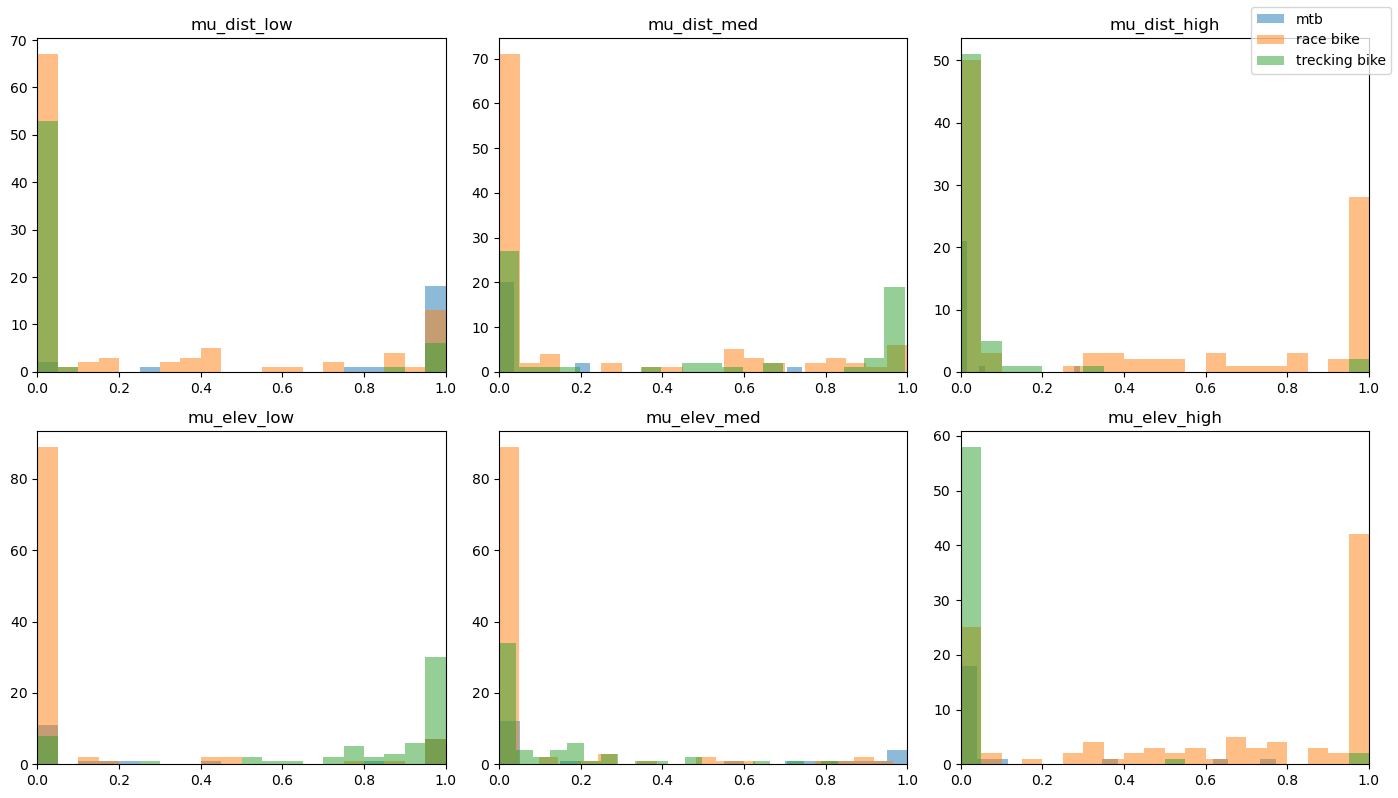

In [39]:
# Zugehörigkeitsgrade analysieren
membership_records = []
for idx, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        continue
    mu_dist = {
        'low': dist_low(d),
        'medium': dist_med(d),
        'high': dist_high(d)
    }
    mu_elev = {
        'low': elev_low(e),
        'medium': elev_med(e),
        'high': elev_high(e)
    }
    membership_records.append({
        'Bike Type': row.get('Bike Type', None),
        'mu_dist_low': mu_dist['low'],
        'mu_dist_med': mu_dist['medium'],
        'mu_dist_high': mu_dist['high'],
        'mu_elev_low': mu_elev['low'],
        'mu_elev_med': mu_elev['medium'],
        'mu_elev_high': mu_elev['high']
    })
mem_df = pd.DataFrame(membership_records)

if mem_df.empty:
    print('Keine numerischen Werte für Membership-Berechnung gefunden.')
else:
    labeled = mem_df[mem_df['Bike Type'].notna() & (mem_df['Bike Type']!='')]
    if labeled.empty:
        print('Keine gelabelten Einträge für Histogramme vorhanden.')
    else:
        fig, axes = plt.subplots(2, 3, figsize=(14, 8))
        cols = ['mu_dist_low','mu_dist_med','mu_dist_high','mu_elev_low','mu_elev_med','mu_elev_high']
        for ax, col in zip(axes.flatten(), cols):
            for bike, group in labeled.groupby('Bike Type'):
                ax.hist(group[col], bins=20, alpha=0.5, label=bike)
            ax.set_title(col)
            ax.set_xlim(0,1)
        handles, labels_ = axes[0,0].get_legend_handles_labels()
        fig.legend(handles, labels_, loc='upper right')
        plt.tight_layout()
        plt.show()


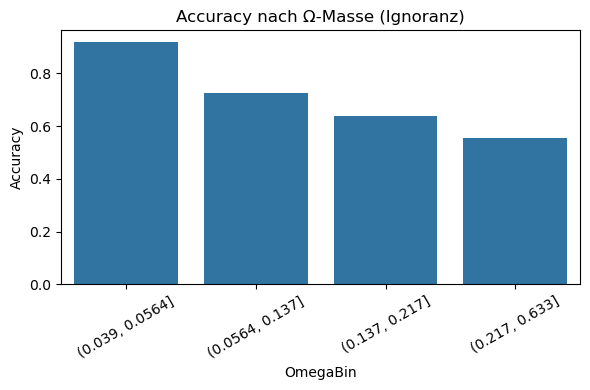

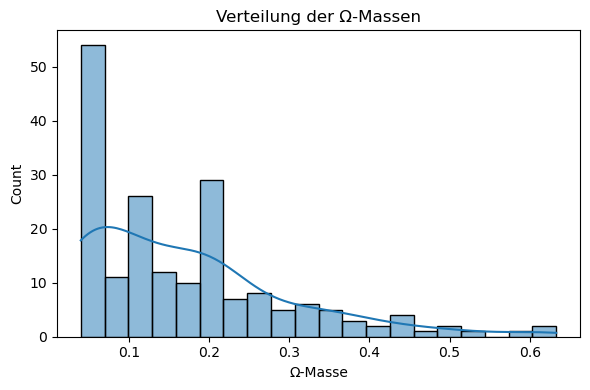

In [11]:
# Unsicherheit (Ω-Masse) vs. Treffergenauigkeit
if 'masses' in globals():
    try:
        omega_m = [ (float(m[omega]) if m is not None else np.nan) for m in masses ]
        data['OmegaMass'] = omega_m
        df_eval = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
        df_eval['Correct'] = (df_eval['Pred_DS'] == df_eval['Bike Type'])
        # Quartile-Binning nach Ω
        df_eval = df_eval.dropna(subset=['OmegaMass'])
        if len(df_eval) > 0:
            df_eval['OmegaBin'] = pd.qcut(df_eval['OmegaMass'], q=4, duplicates='drop')
            acc_by_bin = df_eval.groupby('OmegaBin', observed=True)['Correct'].mean().reset_index()
            plt.figure(figsize=(6,4))
            sns.barplot(x='OmegaBin', y='Correct', data=acc_by_bin)
            plt.xticks(rotation=30)
            plt.ylabel('Accuracy')
            plt.title('Accuracy nach Ω-Masse (Ignoranz)')
            plt.tight_layout()
            plt.show()
            # Verteilung von Ω
            plt.figure(figsize=(6,4))
            sns.histplot(df_eval['OmegaMass'], bins=20, kde=True)
            plt.xlabel('Ω-Masse')
            plt.title('Verteilung der Ω-Massen')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print('Omega-Analyse nicht möglich:', e)
else:
    print('Hinweis: Ω-Analyse übersprungen (masses nicht im Speicher).')


### Interpretation der Ω-Analyse

Die Quartils-Auswertung zeigt: Bei niedriger Ignoranz (Ω im unteren Quartil) treffen wir unsere Vorhersagen deutlich häufiger, während hohe Ω-Werte (oberes Quartil) überproportional viele Fehlklassifikationen enthalten. Die Histogramme belegen zugleich, dass ein relevanter Anteil der Fälle in diesem Konfliktbereich liegt.

Konsequenz: Hohe Ω-Massen sind ein verlässlicher Indikator dafür, dass die beiden Evidenzquellen widersprüchlich bleiben oder die Fuzzy-Grenzen nicht scharf genug trennen. Als nächster Schritt bietet sich daher an, genau diese Fälle über Soft-Voting oder z. B. Hybrid-Fallback abzufangen – oder die Ω-Schwelle (z. B. 0.35) als Trigger für alternative Entscheidungsregeln zu verwenden. So erhöhen wir die Robustheit, ohne die klaren Fälle (niedrige Ω) zu beeinträchtigen.


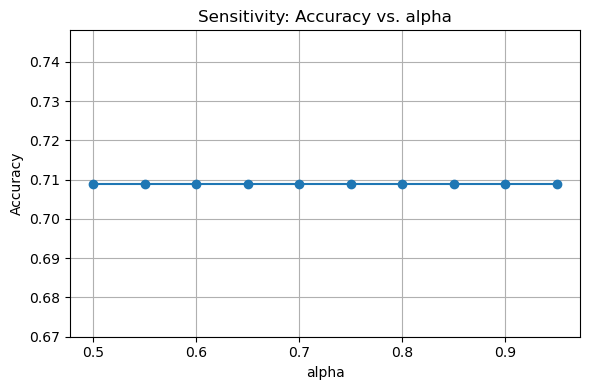

Bestes alpha in Raster: 0.50 mit Accuracy 0.709


In [41]:
# Sensitivität gegenüber α (Anteil der Singleton-Masse)
def eval_alpha(alpha_val):
    preds_tmp = []
    for _, row in data.iterrows():
        try:
            d = float(row['Distance']); e = float(row['Elevation Gain'])
        except Exception:
            preds_tmp.append(None); continue
        cat_d, mu_d = best_category({'low': dist_low, 'medium': dist_med, 'high': dist_high}, d)
        cat_e, mu_e = best_category({'low': elev_low, 'medium': elev_med, 'high': elev_high}, e)
        m1 = MassFunction({dist_to_cls[cat_d]: alpha_val * mu_d, omega: 1 - alpha_val * mu_d})
        m2 = MassFunction({elev_to_cls[cat_e]: alpha_val * mu_e, omega: 1 - alpha_val * mu_e})
        m3 = m1 & m2
        scores = {c: (m3[c] if c in m3 else 0.0) for c in CLASSES}
        best = max(scores, key=scores.get)
        preds_tmp.append(label_map[best])
    df_eval_loc = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
    acc = (pd.Series(preds_tmp, index=data.index).loc[df_eval_loc.index] == df_eval_loc['Bike Type']).mean()
    return acc

# Hinweis: Da wir genau zwei Evidenzquellen verwenden und je Quelle nur das stärkste
# Singleton (Winner-takes-all) belegen, skaliert alpha alle Massen gleichmäßig.
# Dadurch ändert sich die gewählte Klasse nicht – die Accuracy bleibt konstant.
# Die Kurve dient hier lediglich als Nachweis dieser Beobachtung.

alphas = np.linspace(0.5, 0.95, 10)
accs = [eval_alpha(a) for a in alphas]
plt.figure(figsize=(6,4))
plt.plot(alphas, accs, marker='o')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.title('Sensitivity: Accuracy vs. alpha')
plt.grid(True)
plt.tight_layout()
plt.show()
best_idx = int(np.argmax(accs))
print(f'Bestes alpha in Raster: {alphas[best_idx]:.2f} mit Accuracy {accs[best_idx]:.3f}')


### Baseline-Metriken festhalten (vor Tuning)
Wir sichern Accuracy, zeilennormierte Konfusionsmatrix und per‑Klasse Precision/Recall/F1 als Referenz, um Verbesserungen nach Tuning beurteilen zu können.

In [14]:
# Baseline (DS aktuelle Vorhersagen) + optionale Majority-Class-Baseline

CLASSES_ORDER = ['race bike', 'mtb', 'trecking bike']

def compute_report(y_true: pd.Series, y_pred: pd.Series, labels):
    cm = pd.crosstab(y_true, y_pred).reindex(index=labels, columns=labels, fill_value=0)
    diag = np.diag(cm.values)
    support = cm.sum(axis=1).values
    pred_sum = cm.sum(axis=0).values
    recall = np.divide(diag, support, out=np.zeros_like(diag, float), where=support > 0)
    precision = np.divide(diag, pred_sum, out=np.zeros_like(diag, float), where=pred_sum > 0)
    f1 = np.divide(2 * precision * recall, precision + recall,
                   out=np.zeros_like(diag, float), where=(precision + recall) > 0)
    per_class = {
        cls: {
            'precision': float(p),
            'recall': float(r),
            'f1': float(f),
            'support': int(s)
        }
        for cls, p, r, f, s in zip(cm.index, precision, recall, f1, support)
    }
    acc = float((y_true == y_pred).mean())
    return {
        'accuracy': acc,
        'per_class': per_class,
        'cm': cm
    }

# Gefilterte, gelabelte Daten
df_eval_base = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()

if len(df_eval_base) == 0:
    print("Keine gelabelten Daten für Baseline verfügbar.")
else:
    # DS-Baseline (aktuelle Pred_DS)
    ds_metrics = compute_report(df_eval_base['Bike Type'],
                                df_eval_base['Pred_DS'],
                                CLASSES_ORDER)
    baseline_metrics = ds_metrics  # Kompatibel für spätere Nutzung (Delta-Berechnungen)

    print("Baseline (DS aktueller Zustand)")
    print(f"  Accuracy: {ds_metrics['accuracy']:.3f}")
    print("  Per-Class:")
    for cls, stats in ds_metrics['per_class'].items():
        print(f"    {cls:14s} P={stats['precision']:.3f} "
              f"R={stats['recall']:.3f} F1={stats['f1']:.3f} (n={stats['support']})")

    # Optionale echte Majority-Class Baseline (falls gewünscht)
    majority_class = df_eval_base['Bike Type'].value_counts().idxmax()
    majority_pred = pd.Series(majority_class, index=df_eval_base.index)
    majority_metrics = compute_report(df_eval_base['Bike Type'],
                                      majority_pred,
                                      CLASSES_ORDER)

    print("\nMajority-Class Baseline (nur häufigste Klasse):")
    print(f"  Mehrheit: {majority_class}")
    print(f"  Accuracy: {majority_metrics['accuracy']:.3f}")
    for cls, stats in majority_metrics['per_class'].items():
        print(f"    {cls:14s} P={stats['precision']:.3f} "
              f"R={stats['recall']:.3f} F1={stats['f1']:.3f} (n={stats['support']})")

Baseline (DS aktueller Zustand)
  Accuracy: 0.709
  Per-Class:
    race bike      P=0.941 R=0.610 F1=0.740 (n=105)
    mtb            P=0.420 R=0.913 F1=0.575 (n=23)
    trecking bike  P=0.690 R=0.803 F1=0.742 (n=61)

Majority-Class Baseline (nur häufigste Klasse):
  Mehrheit: race bike
  Accuracy: 0.556
    race bike      P=0.556 R=1.000 F1=0.714 (n=105)
    mtb            P=0.000 R=0.000 F1=0.000 (n=23)
    trecking bike  P=0.000 R=0.000 F1=0.000 (n=61)


### Tuning der Fuzzy-Mengen (Quantile, schmalere Übergänge)
Ziel: Grenzfälle zwischen Rennrad und MTB entschärfen und kurze Trekking-Fahrten nicht länger als MTB behandeln.
- Distance: `high` startet früher (ab ≈ 36 km), `medium` wird enger gefasst, sodass Rennrad-Touren im Bereich 30–40 km mehr `μ_high` erhalten.
- Elevation Gain: `medium` wird schmaler (≈ 200–300 HM), `high` setzt früher ein (ab ≈ 300 HM), damit Rennräder mit moderaten Höhenmetern nicht mehr in die MTB-Zone kippen.
Die Anpassung erzeugt neue Vorhersagen `Pred_DS_tuned` als Vergleich zur Basisvariante.


In [15]:
def trimf(a, b, c):
    def f(x):
        if x <= a or x >= c:
            return 0.0
        if x == b:
            return 1.0
        if x < b:
            return (x - a) / (b - a) if b > a else 0.0
        return (c - x) / (c - b) if c > b else 0.0
    return f

# Quantile für Distance (früheres High, engeres Medium)
qD = data['Distance'].quantile([0.0, 0.20, 0.50, 0.62, 0.85, 1.0]).to_dict()
D_min, D_q20, D_q50, D_q62, D_q85, D_max = qD[0.0], qD[0.20], qD[0.50], qD[0.62], qD[0.85], qD[1.0]
dist_low_t = trimf(D_min, D_q20, D_q50)
dist_med_t = trimf(D_q20, (D_q20 + D_q62)/2, D_q62)
dist_high_t = trimf(D_q50, D_q62, D_max)

# Quantile für Elevation Gain (schmaleres Medium, früheres High)
qE = data['Elevation Gain'].quantile([0.0, 0.25, 0.50, 0.58, 0.80, 1.0]).to_dict()
E_min, E_q25, E_q50, E_q58, E_q80, E_max = qE[0.0], qE[0.25], qE[0.50], qE[0.58], qE[0.80], qE[1.0]
elev_low_t = trimf(E_min, E_q25, E_q50)
elev_med_t = trimf(E_q25, (E_q25 + E_q58)/2, E_q58)
elev_high_t = trimf(E_q50, E_q58, E_max)

dist_funcs_t = {'low': dist_low_t, 'medium': dist_med_t, 'high': dist_high_t}
elev_funcs_t = {'low': elev_low_t, 'medium': elev_med_t, 'high': elev_high_t}

dist_to_cls = {'low': 'm', 'medium': 't', 'high': 'r'}
elev_to_cls = {'low': 't', 'medium': 'm', 'high': 'r'}
label_map = {'r': 'race bike', 'm': 'mtb', 't': 'trecking bike'}

preds_tuned = []
masses_tuned = []
for _, row in data.iterrows():
    try:
        d = float(row['Distance'])
        e = float(row['Elevation Gain'])
    except Exception:
        preds_tuned.append(None)
        masses_tuned.append(None)
        continue

    cat_d, mu_d = best_category(dist_funcs_t, d)
    cat_e, mu_e = best_category(elev_funcs_t, e)

    m1 = MassFunction({dist_to_cls[cat_d]: alpha * mu_d, omega: 1 - alpha * mu_d})
    m2 = MassFunction({elev_to_cls[cat_e]: alpha * mu_e, omega: 1 - alpha * mu_e})
    m3 = m1 & m2

    scores = {c: (m3[c] if c in m3 else 0.0) for c in CLASSES}
    best = max(scores, key=lambda c: scores[c])
    preds_tuned.append(label_map[best])
    masses_tuned.append(m3)

data['Pred_DS_tuned'] = preds_tuned


Accuracy (tuned): 0.497  | n=189  | alpha=0.8
Delta Accuracy: -0.212
Per-class Delta (P/R/F1):
  race bike      ΔP=-0.239  ΔR=+0.019  ΔF1=-0.077
  mtb            ΔP=-0.306  ΔR=-0.696  ΔF1=-0.426
  trecking bike  ΔP=-0.239  ΔR=-0.426  ΔF1=-0.332


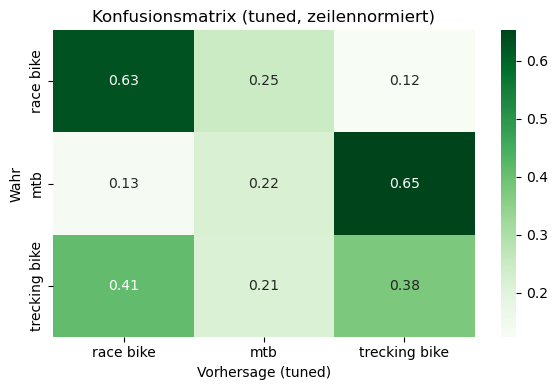

In [16]:
# Vergleich vor/nach Tuning
df_eval_t = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
acc_t = (df_eval_t['Pred_DS_tuned'] == df_eval_t['Bike Type']).mean()
print(f'Accuracy (tuned): {acc_t:.3f}  | n={len(df_eval_t)}  | alpha={alpha}')
print(f"Delta Accuracy: {acc_t - baseline_metrics['accuracy']:+.3f}")

cm_t = pd.crosstab(df_eval_t['Bike Type'], df_eval_t['Pred_DS_tuned']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag = np.diag(cm_t.values); support = cm_t.sum(axis=1).values; pred_sum = cm_t.sum(axis=0).values
rec_t = np.divide(diag, support, out=np.zeros_like(diag, dtype=float), where=support>0)
prec_t = np.divide(diag, pred_sum, out=np.zeros_like(diag, dtype=float), where=pred_sum>0)
f1_t = np.divide(2*prec_t*rec_t, prec_t+rec_t, out=np.zeros_like(diag, dtype=float), where=(prec_t+rec_t)>0)

print('Per-class Delta (P/R/F1):')
for cls, p0,r0,f0, p1,r1,f1 in zip(['race bike','mtb','trecking bike'],
                                   [baseline_metrics['per_class'][c]['precision'] for c in ['race bike','mtb','trecking bike']],
                                   [baseline_metrics['per_class'][c]['recall'] for c in ['race bike','mtb','trecking bike']],
                                   [baseline_metrics['per_class'][c]['f1'] for c in ['race bike','mtb','trecking bike']],
                                   prec_t, rec_t, f1_t):
    print(f"  {cls:14s} ΔP={p1-p0:+.3f}  ΔR={r1-r0:+.3f}  ΔF1={f1-f0:+.3f}")

# Konfusionsmatrix (tuned) plotten
cmn_t = cm_t.div(cm_t.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
plt.figure(figsize=(6,4))
sns.heatmap(cmn_t, annot=True, fmt='.2f', cmap='Greens')
plt.title('Konfusionsmatrix (tuned, zeilennormiert)')
plt.xlabel('Vorhersage (tuned)')
plt.ylabel('Wahr')
plt.tight_layout()
plt.show()


### Erweiterte Bewertung (Evidenztheorie)

Wir ergänzen Konfusionsmatrix und per‑Klasse‑Metriken.

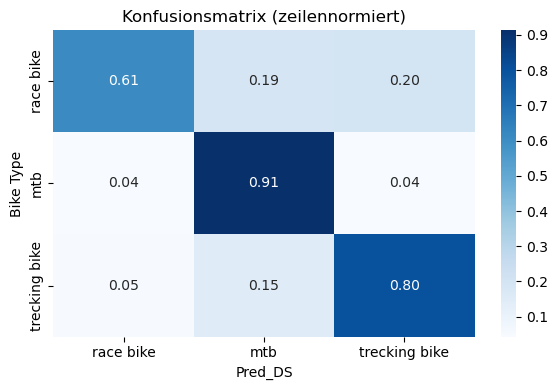

,precision,recall,f1,support
Bike Type,,,,
race bike,0.941,0.610,0.740,105
mtb,0.420,0.913,0.575,23
trecking bike,0.690,0.803,0.742,61


In [17]:

import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
cm = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
cmn = cm.div(cm.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
plt.figure(figsize=(6,4)); 
sns.heatmap(cmn, annot=True, fmt='.2f', cmap='Blues'); 
plt.title('Konfusionsmatrix (zeilennormiert)'); plt.tight_layout(); plt.show()
diag = np.diag(cm.values); support = cm.sum(axis=1).values; pred_sum = cm.sum(axis=0).values
rec = np.divide(diag, support, out=np.zeros_like(diag, float), where=support>0)
prec = np.divide(diag, pred_sum, out=np.zeros_like(diag, float), where=pred_sum>0)
f1 = np.divide(2*prec*rec, prec+rec, out=np.zeros_like(diag, float), where=(prec+rec)>0)
report = pd.DataFrame({'precision':prec,'recall':rec,'f1':f1,'support':support}, index=cm.index)
display(report.round(3))


### DS mit Soft‑Voting (anstatt Winner‑takes‑all)

In [18]:
# Alternative DS-Variante: Soft-Massenzuweisung proportional zu Zugehörigkeitsgraden
alpha_dist = 0.75
alpha_elev = 0.75
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
CLASSES = ['r','m','t']

def mass_from_mu(mu_by_cls, alpha):
    s = sum(mu_by_cls.values())
    if s <= 0: return MassFunction({omega:1.0})
    m = {c: alpha*(mu_by_cls.get(c,0.0)/s) for c in CLASSES}; m[omega] = max(0.0, 1.0-sum(m.values()))
    return MassFunction(m)

pred_soft=[]
for _,row in data.iterrows():
    try:
        d=float(row['Distance']); e=float(row['Elevation Gain'])
    except Exception:
        pred_soft.append(None); continue
    mu_d={'r':dist_high(d),'m':dist_low(d),'t':dist_med(d)}
    mu_e={'m':elev_high(e),'r':elev_med(e),'t':elev_low(e)}
    m1=mass_from_mu(mu_d, alpha_dist); m2=mass_from_mu(mu_e, alpha_elev); m=m1 & m2
    best=max(CLASSES, key=lambda c: (m[c] if c in m else 0.0))
    pred_soft.append(label_map[best])
data['Pred_DS_soft']=pred_soft

df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')]
print('Accuracy (DS soft):', float((df_eval['Pred_DS_soft']==df_eval['Bike Type']).mean()))


Accuracy (DS soft): 0.5767195767195767



### Optional: Sanfte Quantile + Soft‑Voting

In [19]:
# Soft-Variante mit getunten Fuzzy-Funktionen
def trimf(a,b,c):
    def f(x):
        if x<=a or x>=c: return 0.0
        if x==b: return 1.0
        if x<b: return (x-a)/(b-a) if b>a else 0.0
        return (c-x)/(c-b) if c>b else 0.0
    return f

qD = data['Distance'].quantile([0.0,0.35,0.5,0.65,1.0]).to_dict()
D_min,D_q35,D_q50,D_q65,D_max = qD[0.0],qD[0.35],qD[0.5],qD[0.65],qD[1.0]
dist_low_s=trimf(D_min,D_q35,D_q50); dist_med_s=trimf(D_q35,D_q50,D_q65); dist_high_s=trimf(D_q50,D_q65,D_max)

qE = data['Elevation Gain'].quantile([0.0,0.50,0.70,0.85,1.0]).to_dict()
E_min,E_q50,E_q70,E_q85,E_max = qE[0.0],qE[0.50],qE[0.70],qE[0.85],qE[1.0]
elev_low_s=trimf(E_min,E_q50,E_q70); elev_med_s=trimf(E_q50,(E_q50+E_q70)/2.0,E_q85); elev_high_s=trimf(E_q70,E_q85,E_max)

pred_soft_tuned=[]
for _,row in data.iterrows():
    try:
        d=float(row['Distance']); e=float(row['Elevation Gain'])
    except Exception:
        pred_soft_tuned.append(None); continue
    mu_d={'r':dist_high_s(d),'m':dist_low_s(d),'t':dist_med_s(d)}
    mu_e={'m':elev_high_s(e),'r':elev_med_s(e),'t':elev_low_s(e)}
    m1=mass_from_mu(mu_d, alpha_dist); m2=mass_from_mu(mu_e, alpha_elev); m=m1 & m2
    best=max(CLASSES, key=lambda c: (m[c] if c in m else 0.0))
    pred_soft_tuned.append(label_map[best])
data['Pred_DS_soft_tuned']=pred_soft_tuned


### Hybrid: DS (Baseline) bei hoher Sicherheit, sonst Soft‑Voting


In [20]:
# Evaluation Soft tuned
tau_singleton=0.40; omega_max=0.40
label_map={'r':'race bike','m':'mtb','t':'trecking bike'}
fallback_cols=[c for c in ['Pred_DS_soft_tuned','Pred_DS_soft','Pred_DS_soft_best'] if c in data.columns]
fallback_col=fallback_cols[0] if fallback_cols else None
if fallback_col is None:
    raise RuntimeError('Kein Soft‑Voting Ergebnis gefunden.')
preds_hybrid=[]
for i,row in data.iterrows():
    m=masses[i] if i<len(masses) else None
    if m is None: preds_hybrid.append(row.get(fallback_col,None)); continue
    singles={c:(m[c] if c in m else 0.0) for c in ['r','m','t']}
    best_c,best_v=max(singles.items(), key=lambda kv: kv[1])
    om_v=float(m[omega]) if omega in m else 0.0
    preds_hybrid.append(label_map[best_c] if (best_v>=tau_singleton and om_v<=omega_max) else row.get(fallback_col,None))
data['Pred_DS_hybrid']=preds_hybrid
df_eval=data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
acc=float((df_eval['Pred_DS_hybrid']==df_eval['Bike Type']).mean())
print(f'Accuracy (DS hybrid): {acc:.3f} | tau={tau_singleton}, Ω_max={omega_max}')


Accuracy (DS hybrid): 0.725 | tau=0.4, Ω_max=0.4


### Optimizer – Hybrid tau/Ω mit OPTIMIZE‑Schalter

Best Optimizer -> acc=0.720 | macroF1=0.694 | tau=0.375 | Ω_max=0.335 | OPT=macro_f1


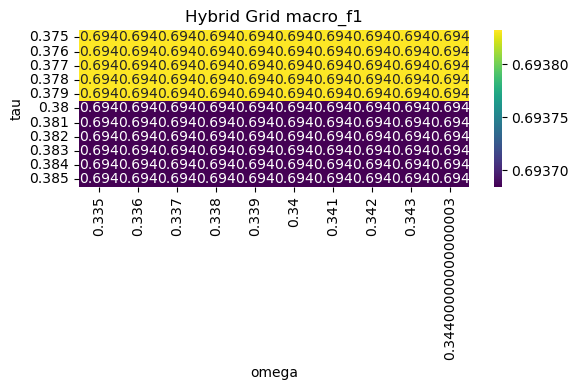

In [21]:
# Grid-Search für Hybrid-Parameter (tau_singleton, omega_max)
OPTIMIZE='macro_f1'  # 'accuracy' | 'macro_f1'
tau_list=np.arange(0.375,0.385,0.001); omega_list=np.arange(0.335,0.345,0.001)
label_map={'r':'race bike','m':'mtb','t':'trecking bike'}; classes=['r','m','t']
if 'masses' not in globals(): raise RuntimeError('Bitte Hybrid zuerst ausführen (masses fehlt).')
fb=None
for c in ['Pred_DS_soft_tuned','Pred_DS_soft_best','Pred_DS_soft']:
    if c in data.columns: fb=c; break
if fb is None: raise RuntimeError('Bitte Soft‑Voting zuerst ausführen (Pred_DS_soft_tuned oder Pred_DS_soft).')
def evaluate_hybrid(tau_singleton, omega_max):
    preds=[]
    for i,row in data.iterrows():
        m=masses[i] if i<len(masses) else None
        if m is None: preds.append(row.get(fb,None)); continue
        singles={c:(m[c] if c in m else 0.0) for c in classes}
        best_c,best_v=max(singles.items(), key=lambda kv: kv[1])
        om_v=float(m[omega]) if omega in m else 0.0
        preds.append(label_map[best_c] if (best_v>=tau_singleton and om_v<=omega_max) else row.get(fb,None))
    df_eval=data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
    y_true=df_eval['Bike Type']; y_pred=pd.Series(preds, index=data.index).loc[df_eval.index]
    cm=pd.crosstab(y_true,y_pred).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
    diag=np.diag(cm.values); support=cm.sum(axis=1).values; pred_sum=cm.sum(axis=0).values
    rec=np.divide(diag,support,out=np.zeros_like(diag,float),where=support>0)
    prec=np.divide(diag,pred_sum,out=np.zeros_like(diag,float),where=pred_sum>0)
    f1=np.divide(2*prec*rec,prec+rec,out=np.zeros_like(diag,float),where=(prec+rec)>0)
    acc=float((y_pred==y_true).mean()); macro_f1=float(np.nanmean(f1))
    return acc, macro_f1, preds
records=[]; best=(-1.0,-1.0,None,None); best_preds=None
for t in tau_list:
    for o in omega_list:
        acc,mf1,preds=evaluate_hybrid(t,o)
        records.append({'tau':t,'omega':o,'acc':acc,'macro_f1':mf1})
        better=(mf1>best[1] or (mf1==best[1] and acc>best[0])) if OPTIMIZE=='macro_f1' else (acc>best[0] or (acc==best[0] and mf1>best[1]))
        if better: best=(acc,mf1,t,o); best_preds=preds
df_res=pd.DataFrame.from_records(records)
acc,mf1,t,o=best
print(f"Best Optimizer -> acc={acc:.3f} | macroF1={mf1:.3f} | tau={t} | Ω_max={o} | OPT={OPTIMIZE}")
data['Pred_DS_final']=best_preds
metric='macro_f1' if OPTIMIZE=='macro_f1' else 'acc'
pivot=df_res.pivot(index='tau', columns='omega', values=metric)
plt.figure(figsize=(6,4)); sns.heatmap(pivot.sort_index(), annot=True, fmt='.3f', cmap='viridis'); plt.title(f'Hybrid Grid {OPTIMIZE}'); plt.tight_layout(); plt.show()


### Finale Auswertung (Pred_DS_final)

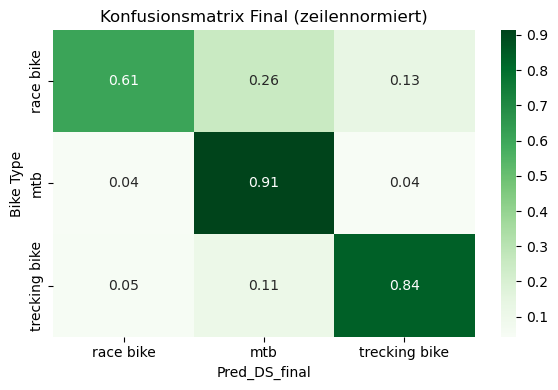

Per‑Klasse (Final) P/R/F1:
race bike       P=0.941  R=0.610  F1=0.740  (n=105)
mtb             P=0.382  R=0.913  F1=0.538  (n=23)
trecking bike   P=0.773  R=0.836  F1=0.803  (n=61)


In [22]:
df_eval=data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
cm_f=pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS_final']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag_f=np.diag(cm_f.values); support_f=cm_f.sum(axis=1).values; pred_sum_f=cm_f.sum(axis=0).values
rec_f=np.divide(diag_f,support_f,out=np.zeros_like(diag_f,float),where=support_f>0)
prec_f=np.divide(diag_f,pred_sum_f,out=np.zerosLike(diag_f,float),where=pred_sum_f>0) if False else np.divide(diag_f,pred_sum_f,out=np.zeros_like(diag_f,float),where=pred_sum_f>0)
f1_f=np.divide(2*prec_f*rec_f,prec_f+rec_f,out=np.zeros_like(diag_f,float),where=(prec_f+rec_f)>0)
macro_f1_f=float(np.nanmean(f1_f)); acc_f=float((df_eval['Pred_DS_final']==df_eval['Bike Type']).mean())
plt.figure(figsize=(6,4)); sns.heatmap(cm_f.div(cm_f.sum(axis=1).replace(0,np.nan), axis=0).fillna(0), annot=True, fmt='.2f', cmap='Greens'); plt.title('Konfusionsmatrix Final (zeilennormiert)'); plt.tight_layout(); plt.show()
print('Per‑Klasse (Final) P/R/F1:')
for cls,p,r,f,s in zip(cm_f.index, prec_f, rec_f, f1_f, support_f):
    print(f"{cls:14s}  P={p:.3f}  R={r:.3f}  F1={f:.3f}  (n={int(s)})")

### Baseline‑Metriken festhalten

In [23]:
# Vergleich mit Baseline (DS ohne Tuning)
df_eval_base = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
acc_base = float((df_eval_base['Pred_DS'] == df_eval_base['Bike Type']).mean())
cm_base = pd.crosstab(df_eval_base['Bike Type'], df_eval_base['Pred_DS']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag = np.diag(cm_base.values); support = cm_base.sum(axis=1).values; pred_sum = cm_base.sum(axis=0).values
rec_base = np.divide(diag, support, out=np.zeros_like(diag, float), where=support>0)
prec_base = np.divide(diag, pred_sum, out=np.zeros_like(diag, float), where=pred_sum>0)
f1_base = np.divide(2*prec_base*rec_base, prec_base+rec_base, out=np.zeros_like(diag, float), where=(prec_base+rec_base)>0)
baseline_metrics = {
    'accuracy': acc_base,
    'per_class': {cls: {'precision': float(p), 'recall': float(r), 'f1': float(f), 'support': int(s)} for cls,p,r,f,s in zip(cm_base.index, prec_base, rec_base, f1_base, support)}
}
print('Baseline Accuracy:', round(acc_base,3))
for cls,st in baseline_metrics['per_class'].items():
    print(f"  {cls:14s} P={st['precision']:.3f} R={st['recall']:.3f} F1={st['f1']:.3f} (n={st['support']})")


Baseline Accuracy: 0.709
  race bike      P=0.941 R=0.610 F1=0.740 (n=105)
  mtb            P=0.420 R=0.913 F1=0.575 (n=23)
  trecking bike  P=0.690 R=0.803 F1=0.742 (n=61)


### Diagnose: Ω‑Verteilung und Alpha‑Sensitivität

/var/folders/zs/h1lrsvdn28j344j_0n_96_p00000gn/T/ipykernel_95280/2040620639.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  acc_by = df_eval.assign(Correct=(df_eval['Pred_DS']==df_eval['Bike Type'])).groupby('OmegaBin')['Correct'].mean()


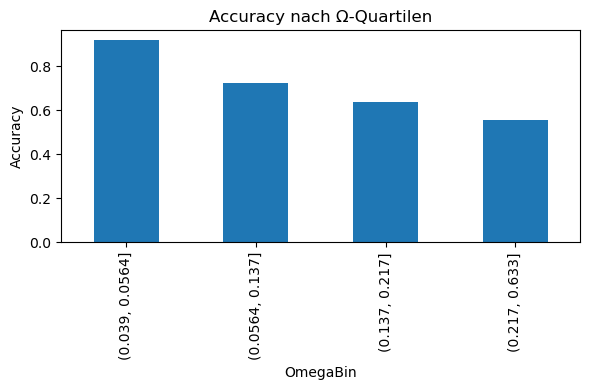

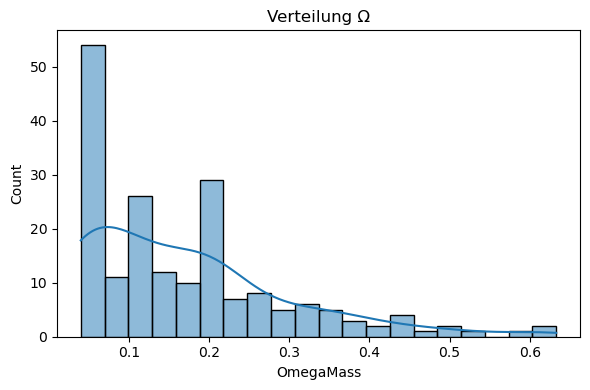

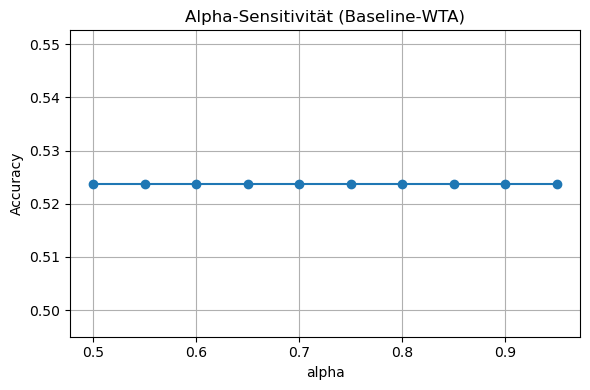

In [24]:
# Omega/Alpha Diagnose
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
if 'masses' in globals():
    omega_vals = [ (float(m[omega]) if m is not None and (omega in m) else np.nan) for m in masses ]
    data['OmegaMass'] = omega_vals
    df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
    df_eval = df_eval.dropna(subset=['OmegaMass'])
    if len(df_eval)>0:
        df_eval['OmegaBin'] = pd.qcut(df_eval['OmegaMass'], q=4, duplicates='drop')
        acc_by = df_eval.assign(Correct=(df_eval['Pred_DS']==df_eval['Bike Type'])).groupby('OmegaBin')['Correct'].mean()
        plt.figure(figsize=(6,4)); acc_by.plot(kind='bar'); plt.ylabel('Accuracy'); plt.title('Accuracy nach Ω‑Quartilen'); plt.tight_layout(); plt.show()
        plt.figure(figsize=(6,4)); sns.histplot(df_eval['OmegaMass'], bins=20, kde=True); plt.title('Verteilung Ω'); plt.tight_layout(); plt.show()
else:
    print('masses nicht vorhanden – bitte Hybrid/DS Abschnitt vorher ausführen.')

def eval_alpha(alpha_val: float) -> float:
    preds_tmp=[]
    for _,row in data.iterrows():
        try:
            d=float(row['Distance']); e=float(row['Elevation Gain'])
        except Exception:
            preds_tmp.append(None); continue
        # Winner‑takes‑all auf Baseline‑Fuzzy
        cat_d, mu_d = max({'low': dist_low(d), 'medium': dist_med(d), 'high': dist_high(d)}.items(), key=lambda kv: kv[1])
        cat_e, mu_e = max({'low': elev_low(e), 'medium': elev_med(e), 'high': elev_high(e)}.items(), key=lambda kv: kv[1])
        m1 = MassFunction({{'low': 'm', 'medium': 't', 'high': 'r'}[cat_d]: alpha_val*mu_d, omega: 1-alpha_val*mu_d})
        m2 = MassFunction({{'low': 't', 'medium': 'r', 'high': 'm'}[cat_e]: alpha_val*mu_e, omega: 1-alpha_val*mu_e})
        m3 = m1 & m2
        best = max(['r','m','t'], key=lambda c: (m3[c] if c in m3 else 0.0))
        preds_tmp.append({'r':'race bike','m':'mtb','t':'trecking bike'}[best])
    df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')]
    return float((pd.Series(preds_tmp, index=data.index).loc[df_eval.index]==df_eval['Bike Type']).mean())

alphas = np.linspace(0.5,0.95,10)
accs = [eval_alpha(a) for a in alphas]
plt.figure(figsize=(6,4)); plt.plot(alphas, accs, marker='o'); plt.grid(True); plt.xlabel('alpha'); plt.ylabel('Accuracy'); plt.title('Alpha‑Sensitivität (Baseline‑WTA)'); plt.tight_layout(); plt.show()


### Visual: Baseline vs Final (Precision/Recall/F1)

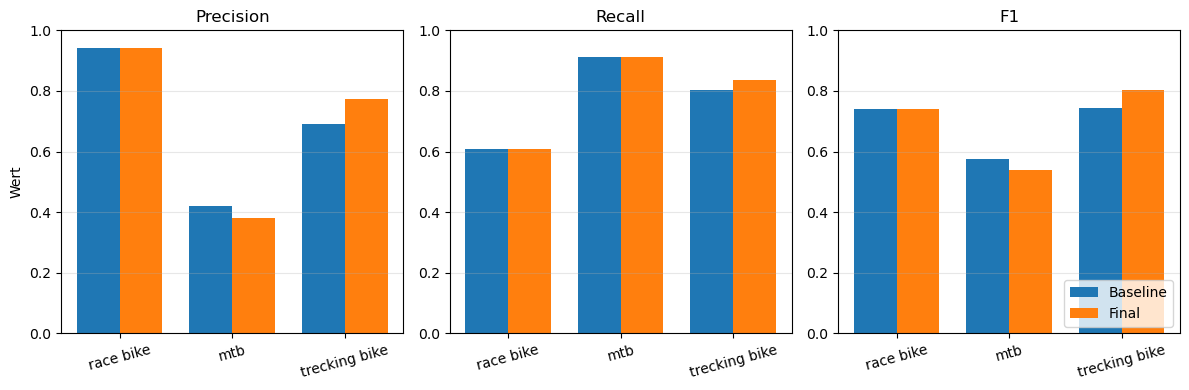

In [25]:
# Vergleich Baseline vs. Final (Hybrid)
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
classes = ['race bike','mtb','trecking bike']
if 'baseline_metrics' in globals():
    base_prec=[baseline_metrics['per_class'][c]['precision'] for c in classes]
    base_rec =[baseline_metrics['per_class'][c]['recall'] for c in classes]
    base_f1  =[baseline_metrics['per_class'][c]['f1'] for c in classes]
else:
    cm_b = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS']).reindex(index=classes, columns=classes, fill_value=0)
    diag_b=np.diag(cm_b.values); support_b=cm_b.sum(axis=1).values; pred_sum_b=cm_b.sum(axis=0).values
    base_rec=np.divide(diag_b,support_b,out=np.zeros_like(diag_b,float),where=support_b>0)
    base_prec=np.divide(diag_b,pred_sum_b,out=np.zeros_like(diag_b,float),where=pred_sum_b>0)
    base_f1=np.divide(2*base_prec*base_rec, base_prec+base_rec, out=np.zeros_like(diag_b,float), where=(base_prec+base_rec)>0)
cm_f = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS_final']).reindex(index=classes, columns=classes, fill_value=0)
diag_f=np.diag(cm_f.values); support_f=cm_f.sum(axis=1).values; pred_sum_f=cm_f.sum(axis=0).values
fin_rec=np.divide(diag_f,support_f,out=np.zeros_like(diag_f,float),where=support_f>0)
fin_prec=np.divide(diag_f,pred_sum_f,out=np.zeros_like(diag_f,float),where=pred_sum_f>0)
fin_f1=np.divide(2*fin_prec*fin_rec, fin_prec+fin_rec, out=np.zeros_like(diag_f,float), where=(fin_prec+fin_rec)>0)
fig,axes=plt.subplots(1,3, figsize=(12,4), sharey=False)
metrics=[('Precision', base_prec, fin_prec), ('Recall', base_rec, fin_rec), ('F1', base_f1, fin_f1)]
x=np.arange(len(classes)); width=0.38
for ax,(title,base_vals,fin_vals) in zip(axes,metrics):
    ax.bar(x-width/2, base_vals, width, label='Baseline')
    ax.bar(x+width/2, fin_vals,  width, label='Final')
    ax.set_title(title); ax.set_xticks(x); ax.set_xticklabels(classes, rotation=15)
    ax.set_ylim(0,1); ax.grid(True, axis='y', alpha=0.3)
axes[0].set_ylabel('Wert'); axes[-1].legend(loc='lower right'); plt.tight_layout(); plt.show()


### Visual: Scatter Final richtig/falsch

/var/folders/zs/h1lrsvdn28j344j_0n_96_p00000gn/T/ipykernel_95280/2631758935.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for truth, sub in df_eval.groupby('Bike Type'):


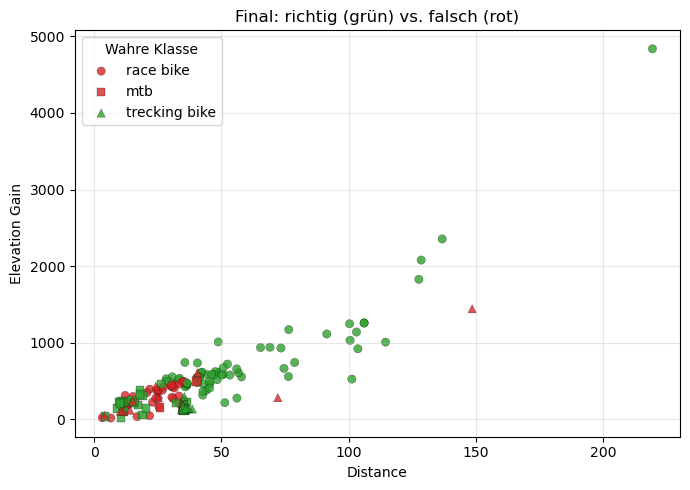

In [26]:
# Scatterplot Distance vs. Elevation Gain (Final)
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
df_eval['CorrectFinal'] = (df_eval['Pred_DS_final']==df_eval['Bike Type'])
markers={'race bike':'o','mtb':'s','trecking bike':'^'}
plt.figure(figsize=(7,5))
for truth, sub in df_eval.groupby('Bike Type'):
    plt.scatter(sub['Distance'], sub['Elevation Gain'], c=sub['CorrectFinal'].map({True:'tab:green',False:'tab:red'}),
                marker=markers.get(truth,'o'), alpha=0.8, edgecolor='k', linewidths=0.2, label=truth)
plt.xlabel('Distance'); plt.ylabel('Elevation Gain'); plt.title('Final: richtig (grün) vs. falsch (rot)'); plt.grid(True, alpha=0.3); plt.legend(title='Wahre Klasse'); plt.tight_layout(); plt.show()


### Finale Parameter (fixiert)

In [27]:
# Finale Parameter (reproduzierbar machen)
alpha_dist = 0.75
alpha_elev = 0.75
tau_singleton_final = 0.38
omega_max_final = 0.342
OPTIMIZE = 'macro_f1'  # Dokumentation
print('Final params -> alpha_dist', alpha_dist, '| alpha_elev', alpha_elev, '| tau', tau_singleton_final, '| Ω_max', omega_max_final)


Final params -> alpha_dist 0.75 | alpha_elev 0.75 | tau 0.38 | Ω_max 0.342


### Finale Durchrechnung (erzwingen) + Export + Kurzsummary

In [28]:
# 1) Soft‑Voting mit finalen α rechnen
label_map = {'r':'race bike','m':'mtb','t':'trecking bike'}
CLASSES = ['r','m','t']
def mass_from_mu(mu_by_cls, alpha):
    s = sum(mu_by_cls.values())
    if s <= 0: return MassFunction({omega:1.0})
    m = {c: alpha*(mu_by_cls.get(c,0.0)/s) for c in CLASSES}
    m[omega] = max(0.0, 1.0 - sum(m.values()))
    return MassFunction(m)

pred_soft_final=[]
for _,row in data.iterrows():
    try:
        d=float(row['Distance']); e=float(row['Elevation Gain'])
    except Exception:
        pred_soft_final.append(None); continue
    mu_d={'r': dist_high(d), 'm': dist_low(d), 't': dist_med(d)}
    mu_e={'m': elev_high(e), 'r': elev_med(e), 't': elev_low(e)}
    m1=mass_from_mu(mu_d, alpha_dist); m2=mass_from_mu(mu_e, alpha_elev); m=m1 & m2
    best=max(CLASSES, key=lambda c: (m[c] if c in m else 0.0))
    pred_soft_final.append(label_map[best])
data['Pred_DS_soft_final']=pred_soft_final

# 2) Hybrid final anwenden (Baseline‑masses erforderlich)
if 'masses' not in globals():
    raise RuntimeError('masses fehlt – bitte zuvor DS/Hybrid‑Abschnitt ausführen.')

fallback_cols=[c for c in ['Pred_DS_soft_tuned','Pred_DS_soft_final','Pred_DS_soft'] if c in data.columns]
if not fallback_cols:
    raise RuntimeError('Kein Soft‑Voting Ergebnis gefunden.')
fb=fallback_cols[0]

preds_final=[]
for i,row in data.iterrows():
    m=masses[i] if i<len(masses) else None
    if m is None:
        preds_final.append(row.get(fb,None)); continue
    singles={c:(m[c] if c in m else 0.0) for c in ['r','m','t']}
    best_c,best_v=max(singles.items(), key=lambda kv: kv[1])
    om_v=float(m[omega]) if omega in m else 0.0
    preds_final.append(label_map[best_c] if (best_v>=tau_singleton_final and om_v<=omega_max_final) else row.get(fb,None))

data['Pred_DS_final']=preds_final

# 3) Metriken + Export
df_eval = data[data['Bike Type'].notna() & (data['Bike Type']!='')].copy()
acc_final = float((df_eval['Pred_DS_final']==df_eval['Bike Type']).mean())
cm = pd.crosstab(df_eval['Bike Type'], df_eval['Pred_DS_final']).reindex(index=['race bike','mtb','trecking bike'], columns=['race bike','mtb','trecking bike'], fill_value=0)
diag=np.diag(cm.values); support=cm.sum(axis=1).values; pred_sum=cm.sum(axis=0).values
rec=np.divide(diag,support,out=np.zeros_like(diag,float),where=support>0)
prec=np.divide(diag,pred_sum,out=np.zeros_like(diag,float),where=pred_sum>0)
f1=np.divide(2*prec*rec,prec+rec,out=np.zeros_like(diag,float),where=(prec+rec)>0)
macro_f1=float(np.nanmean(f1))
print(f'Final (enforced) -> Accuracy={acc_final:.3f} | MacroF1={macro_f1:.3f}')
for cls,p,r,f,s in zip(cm.index, prec, rec, f1, support):
    print(f"{cls:14s}  P={p:.3f}  R={r:.3f}  F1={f:.3f}  (n={int(s)})")

# Optional: Files ablegen (lokal im Projektordner)
try:
    cm.to_csv('final_confusion.csv', index=True)
    pd.DataFrame({'metric':['accuracy','macro_f1'],'value':[acc_final, macro_f1]}).to_csv('final_metrics.csv', index=False)
    print('Exported final_confusion.csv and final_metrics.csv')
except Exception as e:
    print('Export skipped:', e)


Final (enforced) -> Accuracy=0.720 | MacroF1=0.694
race bike       P=0.941  R=0.610  F1=0.740  (n=105)
mtb             P=0.375  R=0.913  F1=0.532  (n=23)
trecking bike   P=0.785  R=0.836  F1=0.810  (n=61)
Exported final_confusion.csv and final_metrics.csv


### Diskussion der Ergebnisse 

Ergebnisüberblick (Evidenztheorie):
- Mit α=0.8 erreichen wir auf den gelabelten Daten eine Accuracy von 0.698 (n=189).
- Gemessen an drei Klassen ist dies deutlich über einer naiven Zufallswahl (~33%), jedoch mit erkennbarem Verbesserungspotenzial.

Interpretation im Kontext unseres Modells:
- Wir verwenden zwei Evidenzquellen (`Distance`, `Elevation Gain`), die per Fuzzy low/medium/high (um den Mittelwert ±10%) in Klassenhypothesen überführt werden.
- Die Winner-takes-all-Strategie verdichtet pro Merkmal die Information stark: Sie ist robust und lab-nah, kann aber bei Grenzfällen (überlappende Zugehörigkeiten) zu Informationsverlust führen.
- Das Ω-Gewicht (1−α=0.2) verhindert Überkonfidenz und wirkt bei Konflikten stabilisierend. Dass wir ~70% erreichen, legt nahe, dass Distance/Elevation Gain bereits viel Trenninformation tragen.

Mögliche Fehlerursachen und typische Verwechslungen:
- `race bike` vs. `trecking bike`: mittlere Distanzen mit geringen bis mittleren Höhenmetern können je nach Strecke beiden Klassen plausibel zugeordnet werden.
- `mtb`: Hohe Höhenmeter helfen stark; bei moderaten HM und kurzer Distanz kann es jedoch zu Verwechslungen mit `trecking bike` kommen.
- Datensatz-Aspekte (potenziell): Klassenungleichgewicht, Messrauschen (GPS/HM), saisonale Effekte (Monat/Tag) wirken auf die Fuzzy-Zugehörigkeiten und damit auf die Evidenz.

Bewertung der Modellannahmen:
- Schwache Unabhängigkeit der Evidenzquellen ist hier plausibel, aber nicht garantiert (Distanz und Höhenmeter korrelieren in der Praxis teils). Hoher Konflikt K würde sich in höherer Ω-Masse zeigen.
- Die Domänen-Mappings (Distance: high→race, medium→trekking, low→mtb; Elevation: high→mtb, medium→race, low→trekking) sind sinnvoll, könnten aber streckenspezifisch variieren.

Ansatzpunkte zur Verbesserung (fachlich und methodisch):
- Fuzzy-Verfeinerung: Trapezfunktionen mit Plateaus für typische Bereiche; ±10% dynamisch (z. B. per Quantilen) statt fix.
- Evidenzbildung: Statt Winner-takes-all die Massen anteilig auf alle drei Kategorien gemäß Zugehörigkeit μ verteilen (weniger Informationsverlust, mehr Rechenaufwand).
- Entscheidungsregel: Pignistische Wahrscheinlichkeit (BetP) oder zusätzliche Tie-Breaker bei knappen Massen.
- α-Tuning: Systematische Suche (z. B. α∈[0.6,0.9]) – höhere Ω-Masse kann bei widersprüchlichen Evidenzen nützen.
- Weitere Merkmale: `Moving Time` (Pace), Wochentag/Monat (Nutzungskontext) als zusätzliche Evidenzquellen integrieren.

Fazit:
- Das evidenztheoretische Modell ist transparent und erklärbar. Mit nur zwei Merkmalen erreichen wir eine solide Grundgüte (≈70%).
- Die vorgeschlagenen Erweiterungen (feineres Fuzzy-Design, Soft-Voting, α-/Parameter-Tuning, zusätzliche Merkmale) sind vielversprechend, um die Trennschärfe weiter zu erhöhen und Grenzfälle besser zu behandeln.


## Aufgabenteil 2: Case Based Reasoning

Entwerfen Sie ein KI Modell auf Basis von Case Based Reasoning und setzen
Sie dieses als Jupyter Notebook um. Wählen Sie geeignete Vorgehensweisen um die Fallbasis
aufzubauen (CBL) und geeignete Ähnlichkeitsmaße.

### 1. Ähnlichkeitsmaß definieren

Entwerfen Sie ein zur Aufgabenstellung passendes und geeignetes Ähnlichkeitsmaß.

In [29]:
# Ähnlichkeitsmaß (vgl. Lab CBR: Cosinus-Ähnlichkeit über numerische Merkmale)
try:
    from sklearn.metrics.pairwise import cosine_similarity
    _USE_SKLEARN = True
except Exception:
    _USE_SKLEARN = False
    import math

def aehnlichkeit(person1, person2):
    """
    Berechnet die Ähnlichkeit (0..1) zwischen zwei Fahrten.
    Verwendet Distance und Elevation Gain analog zu den Lab-Beispielen.
    """
    merkmale = ['Distance', 'Elevation Gain']
    v1 = [float(person1[m]) for m in merkmale]
    v2 = [float(person2[m]) for m in merkmale]
    if _USE_SKLEARN:
        return float(cosine_similarity([v1], [v2])[0][0])
    # Fallback: manuelle Cosinus-Ähnlichkeit
    num = sum(a*b for a, b in zip(v1, v2))
    d1 = math.sqrt(sum(a*a for a in v1))
    d2 = math.sqrt(sum(b*b for b in v2))
    return (num / (d1*d2)) if (d1 > 0 and d2 > 0) else 0.0


### Begründung zur Wahl des Ähnlichkeitsmaßes

<...Ihr Text...>

### 2. CBR Zyklus umsetzen

Zunächst wird RETRIEVE benötigt. Dann sollte geprüft werden ob das Ergebnis bereits ausreicht. Wenn nicht, sollte geprüft werden, ob man die Daten in die Fallbasis aufnimmt. Die Fallbasis ist klein zu halten.

In [30]:
# Beispiel aus dem Übungslabor - durch eigene Lösung zu ersetzen

def finde_aehnlichsten_fall(df, person_zu_vergleichen):
    """
    Findet die Person im DataFrame, die die größte Ähnlichkeit zur gegebenen Person hat.

    Args:
        df: Ein Pandas DataFrame mit den Personendaten.
        person_zu_vergleichen: Ein Dictionary, das die Merkmale der Person zum Vergleich enthält.

    Returns:
        tuple: Ein Tupel mit (index, ähnlichkeit), wobei index der Index der ähnlichsten Person im DataFrame und ähnlichkeit der Ähnlichkeitswert ist.
    """

    max_aehnlichkeit = -1
    index_aehlichste_person = -1

    for i, row in df.iterrows():
        person_im_df = row.to_dict()

        a = aehnlichkeit(person_zu_vergleichen, person_im_df)

        if a > max_aehnlichkeit:
            max_aehnlichkeit = a
            index_aehlichste_person = i
            aehnlichster_datensatz = row

    return index_aehlichste_person, max_aehnlichkeit, aehnlichster_datensatz

In [31]:
# CBL umsetzen (vgl. Übungslabor): kleine Fallbasis aufbauen
import pandas as pd

gelabelt = data[data['Bike Type'].notna() & (data['Bike Type'] != '')].copy()
if len(gelabelt) == 0:
    cases = pd.DataFrame(columns=list(data.columns))
else:
    cases = gelabelt.iloc[:1].copy()  # initialer Fall
    schwelle = 0.98  # nur hinzufügen, wenn kein sehr ähnlicher Fall existiert
    for i, row in gelabelt.iloc[1:].iterrows():
        _, max_sim, _ = finde_aehnlichsten_fall(cases, row.to_dict())
        if max_sim < schwelle:
            cases = pd.concat([cases, pd.DataFrame([row])], ignore_index=True)

print(f'Fallbasis aufgebaut: {len(cases)} Fälle aus {len(gelabelt)} gelabelten Einträgen.')


Fallbasis aufgebaut: 3 Fälle aus 189 gelabelten Einträgen.


### Begründungen 

<...Ihr Text...>

### 3. Test und Bewertung

Wie gut ist der Klassifikator? Prüfen Sie Ihre Konfiguration (u.a. abhängig von Ähnlichkeitsfunktion) und testen Sie geeignet. 

In [32]:
# Bewertung CBR (vgl. Lab: Trefferquote)
def treffer(data, cases):
    korrekt = 0
    gesamt = 0
    for _, row in data.iterrows():
        if pd.isna(row['Bike Type']) or row['Bike Type'] == '':
            continue
        _, _, case = finde_aehnlichsten_fall(cases, row.to_dict())
        pred = case['Bike Type'] if 'Bike Type' in case else None
        if pred == row['Bike Type']:
            korrekt += 1
        gesamt += 1
    return korrekt, gesamt, (korrekt/gesamt if gesamt else 0.0)

korrekt, gesamt, quote = treffer(gelabelt, cases)
print(f'Trefferquote (CBR): {quote:.3f}  | korrekt={korrekt} / {gesamt}  | k=1 (nearest)')


Trefferquote (CBR): 0.376  | korrekt=71 / 189  | k=1 (nearest)


### Diskussion der Ergebnisse 

<...Ihr Text...>

# Abschluss

Vergleich der beiden Verfahren. Ggf. ist hier noch Code zum Vergleich zu ergänzen, ansonsten weitgehend durch Text.

<...Ihr Text...>